['0.00001']
['0.00001', '', '\n0.00004']
['0.00001', '', '\n0.00001', '', '\n0.00001']
['0.00001', '', '\n0.00001', '', '\n0.00003', '', '\n0.00002']
['0.00001', '', '\n0.00003', '', '\n0.00004', '', '\n0.00003', '', '\n0.00002']
['0.00002', '', '\n0.00002', '', '\n0.00004', '', '\n0.00004', '', '\n0.00004', '', '\n0.00005']
['0.00001', '', '\n0.00002', '', '\n0.00003', '', '\n0.00002', '', '\n0.00003', '', '\n0.00002', '', '\n0.00004']
['0.00002', '', '\n0.00001', '', '\n0.00002', '', '\n0.00001', '', '\n0.00003', '', '\n0.00002', '', '\n0.00136', '', '\n0.02797']
['0.00002', '', '\n0.00004', '', '\n0.00002', '', '\n0.00002', '', '\n0.00002', '', '\n0.00013', '', '\n0.00004', '', '\n0.00017', '', '\n0.00002']


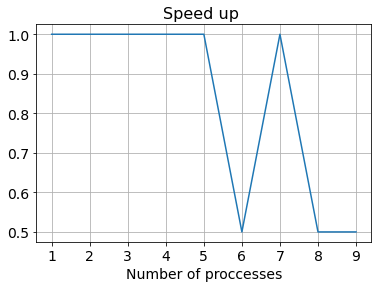

In [2]:
import subprocess
import matplotlib.pyplot as plt
import numpy as np

times = [] # time array
for i in range(1, 10):
    a = subprocess.run(["mpirun","-n", str(i), "python3", "-m", "mpi4py", "test.py"],            
        universal_newlines=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE)
    res = list(a.stdout.strip().split(' '))
    print(res)
    times.append(res[0])

times = list(map(float, times))

plt.title('Speed up ', fontsize=16)
plt.plot(times[0]/np.array(times) )
plt.xlabel("Number of proccesses", fontsize=14)
plt.xticks(np.arange(0, len(times)), np.arange(1, len(times)+1),  fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.savefig('Speed up for mpi.png', bbox_inches='tight')
plt.show()

In [1]:
%%writefile test.py

from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
size = comm.size
rank = comm.Get_rank()

if (rank == 0):
    A = np.random.rand(500000, 100)
    B = np.random.rand(100, 10)

    for i in range(1, size):
        comm.send((A, B), dest=i)
else:
    A, B = comm.recv(source=0)

N = A.shape[0]
start_time = MPI.Wtime()
if (rank != size - 1):
    A_part = A[int(0 + rank * (N // size)) : int(0 + (rank + 1) * (N // size)), :]
else:
    A_part = A[int(0 + rank * (N // size)) : , :]
    
    
if rank == 0:
    time = MPI.Wtime()

AB = comm.gather(A_part.dot(B), root=0)
if (rank == 0):
    AB = np.concatenate((AB), axis=0)
    print(f"{time - start_time:.5f}", ' ')
    #print(AB)

Overwriting test.py


In [56]:
%%writefile test_jax.py
import jax.numpy as jnp
from jax.config import config
import time
config.update("jax_enable_x64", True)

def jax_matmul(A, B):
    return (jnp.array(A) @ jnp.array(B)).block_until_ready()

A = np.random.rand(50000, 10)
B = np.random.rand(10, 10)

start_time = time.time()
AB = jax_matmul(A, B)
time = time.time()
print(f"{time - start_time:.5f}", ' ')


Overwriting test_jax.py


In [2]:
import jax.numpy as jnp
from jax.config import config
import time
config.update("jax_enable_x64", True)
import numpy as np

def jax_matmul(A, B):
    return (jnp.array(A) @(jax) jnp.array(B)).block_until_ready()

A = np.random.rand(50000, 10)
B = np.random.rand(10, 10)

start_time = time.time()
AB = jax_matmul(A, B)
time = time.time()
print(f"{time - start_time:.5f}", ' ')

from numba import jit

@jit(nopython=True)
def numba_matmul(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]
    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                c[i, j] += a[i, s] * b[s, j]
    return c

def matmul_numpy_in(A, B):
    return A @ B


def matmul_numpy(a, b):
    n = a.shape[0]
    k = a.shape[1]
    m = b.shape[1]  
    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                c[i, j] += a[i, s] * b[s, j]        
    return c


def python_product(A,B):
    AB = []
    for i in range(0, len(A)):
        row = []
        for j in range(0, len(B[0])):
            sum = 0.0
            for k in range(0, len(A[0])):
                sum += A[i][k] * B[k][j]
            row.append(sum)
        AB.append(row)
    return AB

0.05493  


In [5]:
from tqdm.notebook import tqdm
ns = np.logspace(1, 5, 6)

times_python_product = []
times_numba_matmul = []
times_matmul_numpy_in = []
times_matmul_numpy = []
times_jax = []

for n in tqdm(ns):
    n = int(n)
    
    A = np.random.rand(n, 100)
    B = np.random.rand(100, 1000)

    a = %timeit -o numba_matmul(A, B)
    times_numba_matmul.append(a.average)
    
    a = %timeit -o matmul_numpy_in(A, B)
    times_matmul_numpy_in.append(a.average)
    
    a = %timeit -o matmul_numpy(A, B)
    times_matmul_numpy.append(a.average)
    
    a = %timeit -o python_product(A, B)
    times_python_product.append(a.average)
    
    a = %timeit -o jax_matmul(A, B)
    times_jax.append(a.average)

  0%|          | 0/6 [00:00<?, ?it/s]

1.69 ms ± 275 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
185 µs ± 49.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
573 ms ± 111 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
667 ms ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
686 µs ± 14.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
10.8 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
424 µs ± 86.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.5 s ± 277 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.99 s ± 223 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.12 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
67.6 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.36 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
22.4 s ± 723 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.3 s ± 1.57 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.57 ms ± 38.4 µs per lo

KeyboardInterrupt: 

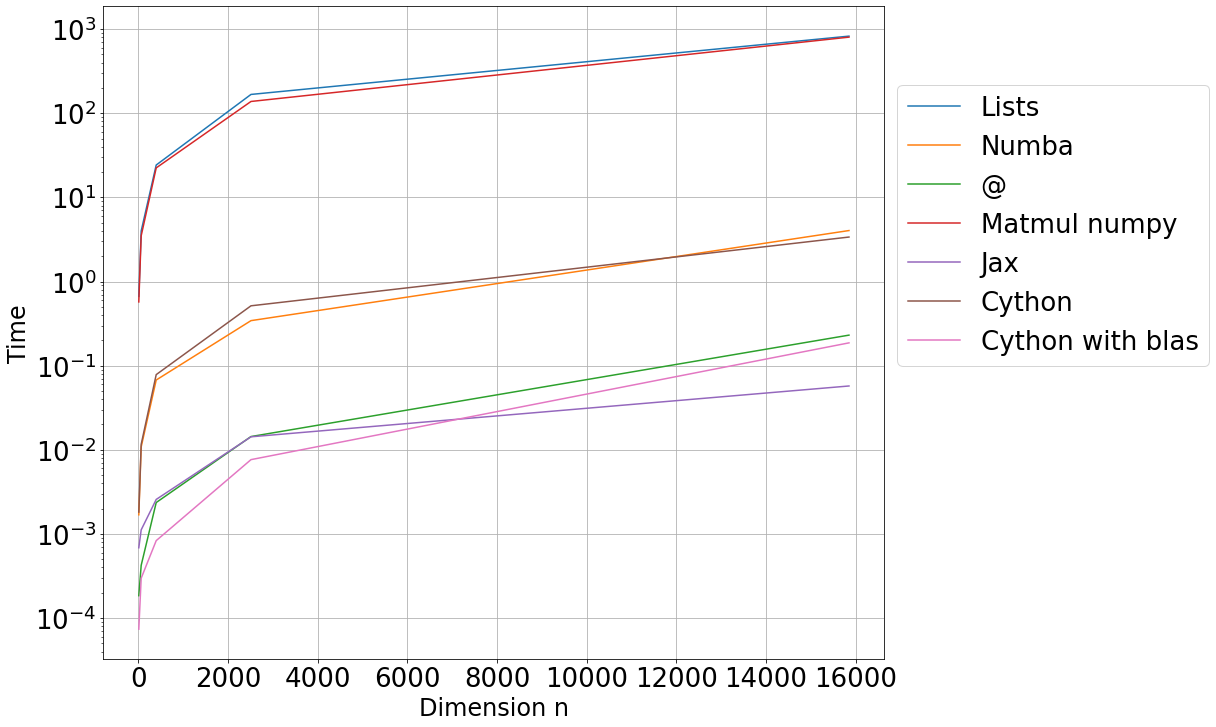

In [26]:
plt.figure(figsize=(14,12))
plt.plot(ns[:5], times_python_product, label = 'Lists')
plt.plot(ns[:5], times_numba_matmul[:5], label = 'Numba')
plt.plot(ns[:5], times_matmul_numpy_in[:5], label = '@')
plt.plot(ns[:5], times_matmul_numpy[:5], label = 'Matmul numpy')
plt.plot(ns[:5], times_jax[:5], label = 'Jax')
plt.plot(ns[:5], times_cython, label = 'Cython')
plt.plot(ns[:5], times_cython_blas, label = 'Cython with blas')
plt.yscale('log')
plt.xlabel("Dimension n", fontsize=24)
plt.ylabel("Time", fontsize=24)
plt.legend(fontsize = 26, bbox_to_anchor = (1.0, 0.9))
plt.grid(True)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.savefig('Test.png',  bbox_inches='tight')
plt.show()

In [16]:
%load_ext Cython

In [ ]:
%%cython

import cython
import numpy as np
from cpython.mem cimport PyMem_Malloc, PyMem_Realloc, PyMem_Free
from libc.stdlib cimport malloc, free
cimport numpy as np
cimport scipy.linalg.cython_blas as blas

def matmul_blas(double[:,:] A, double[:, :] B):
    cdef int N = A.shape[0], M = A.shape[1], K = B.shape[1]
    cdef np.ndarray[np.float64_t, ndim=2, mode = 'fortran'] C = np.empty((N, K), dtype=np.float64, order='F')
    cdef double alpha = 1.0
    cdef double beta = 0.0
    
    blas.dgemm("N", "N", &N, &K, &M, &alpha, &A[0,0], &N, 
              &B[0,0], &M, &beta, &C[0,0], &N)
    return C

@cython.boundscheck(False)
def matmul(double[:,:] A, double[:, :] B):
    cdef int i, j, k
    cdef Py_ssize_t N = A.shape[0], M = A.shape[1], K = B.shape[1] 
    cdef double *res = <double *>malloc(N * K * sizeof(double));
    try:
        with cython.nogil:
            for i in range(N):
                for j in range(K):
                    res[i * K + j] = 0
                    for k in range(M):
                        res[i * K + j] += A[i,k] * B[k,j]
        return [x for x in res[:N*K]]
    finally:
        free(res)